In [56]:
from explainers.gnninterpreter import * 


In [57]:
import torch
from torch import nn

import libraries.dataLoaderWrapper 

In [58]:
dataset = torch.load('model/loader_house_gnn_interpreter_model.pt')

In [59]:
model = GCNClassifier(node_features=3,
                      num_classes=2,
                      hidden_channels=32)

model.load_state_dict(torch.load('model/house_gnn_interpreter_model.pt'))

<All keys matched successfully>

In [60]:
mean_embeds = dataset.mean_embeddings(model)

In [61]:
dataset[0].x

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])

In [62]:
trainer = {}
sampler ={}

In [63]:
cls_idx = 0
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=3,
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [64]:
trainer[0].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

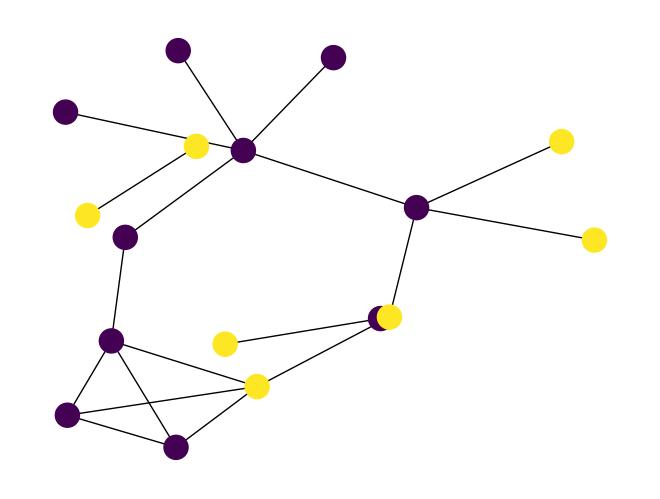

In [65]:
graph = trainer[0].evaluate(threshold=0.5, show=False)
labels = [graph.nodes[node]['label'] for node in graph.nodes]
import networkx as nx
nx.draw(graph, nx.kamada_kawai_layout(graph), node_color=labels)

In [66]:
graph

In [67]:
node_data = graph.nodes(data=True)

# Extract labels and assign colors based on the color map
node_colors = [label_color_map[data['label']] for _, data in node_data]

In [68]:
node_data

NodeDataView({1: {'label': 2}, 15: {'label': 1}, 2: {'label': 1}, 5: {'label': 1}, 6: {'label': 1}, 3: {'label': 1}, 4: {'label': 2}, 18: {'label': 2}, 8: {'label': 1}, 10: {'label': 1}, 13: {'label': 2}, 14: {'label': 1}, 16: {'label': 1}, 9: {'label': 2}, 12: {'label': 1}, 11: {'label': 2}, 17: {'label': 2}})

In [69]:
nx.draw(graph, with_labels=True, node_color=node_data.data['label'])

AttributeError: 'NodeDataView' object has no attribute 'data'